# Step 1 and 2: Extracting Sentences and Pre-processing Input

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [37]:
import re
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

def extract_sentences(pattern, file_path):
  # pattern:   is the regular expression you have defined to extract sentences
  # file_path: path to the transcript file 

  # key: Juror   value: sentences said

  dictionary_lines = {}

  with open(file_path, 'r', encoding="unicode_escape") as file:
    line = file.readline()
    while(line):
      # NOTE: working with 1164 lines TOTAL (before searching for Juror lines)
      # Checks each line to see if it matches our pattern
      #  and adds juror and their lines to dictionary

      # Search for a match of our regex pattern on this line
      match = re.search(pattern, line)
      # If match is found
      if(match):
        # Get the last group result (which has our string after the pattern)
        #  and separate our juror name from their line
        pairs = re.split(pattern, line)[6].split(" ", 1)

        # If we have a juror name AND a line
        if(len(pairs) > 1):
          # Get our juror
          juror = match.group()
          # Remove the word "Juror" from the first 12 lines
          juror = re.sub('(?i)(^(juror)+)', '', juror, flags = re.IGNORECASE).replace(" ", "")
          # Get our sentence
          sentence = pairs[1]
           
          # If this juror isn't in our dictionary
          if(juror not in dictionary_lines):
            # Add the juror and a list item to hold lines
            dictionary_lines[juror] = []

          # Add this line to the juror's key
          dictionary_lines[juror].append(sentence)

      # Read the next line
      line = file.readline()

  # Uncomment to check content of juror lines
  #print(dictionary_lines['FOREMAN'])

  # Printing the number of sentences said by each juror (just for checking)
  for juror in dictionary_lines:
    print(juror + "\t" + str(len(dictionary_lines[juror])))
  
  return dictionary_lines

def pre_process_inputs(dictionary_lines):
  # This method takes in the dictionary from previous method
  # It will return two dictionaries: one having all the tokens along
  # with their frequencies (list to counter?)
  # The other dictionary will have juror as the key (e.g., NO.2)
  # and the values are another dictionary of {token: frequency} for each juror
  
  lst_all_words = []
  dictionary_juror_words = {}
  for juror in dictionary_lines:
    # Here update all the words list and the dictionary for each juror
    lst_of_sentences_by_juror = dictionary_lines[juror]
    words_per_juror = []
    for sentence in lst_of_sentences_by_juror:
      # Filter the sentence to remove unnecessary characters
      #  and convert words to lowercase
      tokenizer = nltk.RegexpTokenizer(r'\w+')
      for word in tokenizer.tokenize(sentence):
        words_per_juror.append(word.lower())
      
    # Add our found words from the juror to our list of all words  
    lst_all_words.extend(words_per_juror)
    # Also add all of the jurors words to our dictionary
    dictionary_juror_words[juror] = dict(Counter(words_per_juror))

  vocabulary = dict(Counter(lst_all_words))
  #del vocabulary['1s']
  #print(len(vocabulary))
  #print(vocabulary)
  return vocabulary, dictionary_juror_words

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Step 3: Building a Uni-gram language model with add-one smooting

In [38]:
from collections import Counter

def unigram_lm(dic_vocabulary, dic_juror_words):
  # This method will generate the unigram language model for each juror
  # The return value is a dict with juror as key and value as his language model
  # the inputs are the two dictionaries from pre_process_inputs method
  dic_unigram_lm = {}

  for juror in dic_juror_words:
    dic_words_frequency = dic_juror_words[juror]
    language_model = {key: 0 for key in dic_vocabulary}
    juror_vocabulary_total = sum(dic_words_frequency.values())
    total_words = len(language_model)
    # Here you will calculate the probabilities with MLE and add-one smoothing
    for key in language_model:
      count = dic_words_frequency.get(key, 0)
      language_model[key] = float(count + 1)/float(total_words + juror_vocabulary_total + 1)
      
    dic_unigram_lm[juror] = language_model

  #print(dic_unigram_lm)
  return dic_unigram_lm

# Step 4: Generate T-SNE plot

In [64]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import numpy as np


def tsne_generator(dic_unigram_lm):
  tsne = TSNE(n_components=2, random_state=0)
  lst_freq = []
  lst_names = []
  
  for juror in dic_unigram_lm:
    lst_names.append(juror)
    
    # frequencies is a dictionary of token: frequencies
    # sort this by key and then convert values to the list and append it 
    # to the lst_freq
    frequencies = dic_unigram_lm[juror]
    # Sort the dictionary by key and store the sorted items in a list
    sorted_frequencies = dict(sorted(frequencies.items()))
    freq = list(sorted_frequencies.values())
    lst_freq.append(freq)
  
  # Convert the list to a NumPy array
  np_array = np.array(lst_freq)
  data = np_array

  # getting vectors with tsne
  vectors = tsne.fit_transform(data)

  # Some codes here to define what to be shown
  fig, ax = plt.subplots()
  plt.scatter(vectors[:, 0], vectors[:, 1])

  for i in range(len(vectors)):
    plt.annotate(lst_names[i], xy=(vectors[i, 0], vectors[i, 1]))

  # making sure the legend is shown (uncomment)
  ax.legend(bbox_to_anchor=(1.1, 1.05))
  ax.grid(True)
  plt.show()
  plt.savefig("my_plot.png")

Block for running all code:

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


FOREMAN	53
NO.2	23
NO.3	94
NO.4	33
NO.5	30
NO.6	19
NO.7	41
NO.8	93
NO.9	20
NO.10	37
NO.11	23
NO.12	14


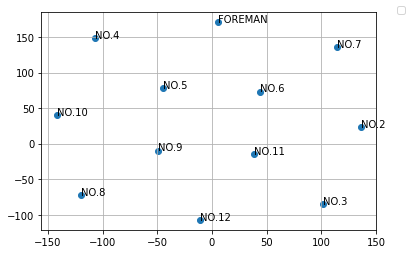

<Figure size 432x288 with 0 Axes>

In [65]:
pattern = '(?:(?i)(^(foreman)+)|(^((juror )*[NO]+[\.]\ *[0-9][0-9]*)))'
path = "/content/12AngryMen.txt";
dic1 = extract_sentences(pattern, path)
dic2, dic3 = pre_process_inputs(dic1)
dic4 = unigram_lm(dic2, dic3)
tsne_generator(dic4)